In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
from collections import Counter

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, precision_recall_curve, hamming_loss, 
                            jaccard_score, classification_report, confusion_matrix)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yash_26\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yash_26\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yash_26\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yash_26\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# 2. Data Exploration and Preprocessing
# -----------------------------------

# 2.1 Load the dataset
df = pd.read_csv('dataset.csv')

# 2.2 Explore dataset information
print("Dataset info:")
df.info()

# Extract main columns for classification
df_main = df[['Plot', 'Genre']].copy()

# Optional metadata for future use
if all(col in df.columns for col in ['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page']):
    df_metadata = df[['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page']].copy()
    print(f"Metadata shape: {df_metadata.shape}")

print(f"Main classifier data shape: {df_main.shape}")


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB
Metadata shape: (34886, 6)
Main classifier data shape: (34886, 2)


In [5]:
# Display first few rows
df_main.head()

,Plot,Genre
0,"A bartender is working at a saloon, serving dr...",unknown
1,"The moon, painted with a smiling face hangs ov...",unknown
2,"The film, just over a minute long, is composed...",unknown
3,Lasting just 61 seconds and consisting of two ...,unknown
4,The earliest known adaptation of the classic f...,unknown


In [7]:
# 2.3 Extract and analyze genre distribution

# Function to extract all genres from the dataset
def extract_all_genres(df):
    all_genres = []
    
    for genre_text in df['Genre']:
        if isinstance(genre_text, str):
            # Split using multiple potential delimiters
            genres = re.split(r'[,|;/]', genre_text)
            # Clean up each genre
            genres = [g.strip() for g in genres if g.strip()]
            all_genres.extend(genres)
    
    return all_genres

# Count all genres
all_genres = extract_all_genres(df_main)
genre_counts = Counter(all_genres)

Genre counts:
drama: 7913
unknown: 6083
comedy: 5799
action: 2108
romance: 1811
horror: 1450
thriller: 1420
crime: 988
western: 936
adventure: 777
musical: 746
family: 504
science fiction: 504
romantic comedy: 493
crime drama: 476
fantasy: 463
mystery: 462
war: 405
sci-fi: 361
film noir: 347
animation: 330
biography: 297
animated: 255
comedy-drama: 173
musical comedy: 154
suspense: 145
historical: 131
social: 127
anime: 119
romantic drama: 108
comedy drama: 104
martial arts: 99
spy: 92
animated short: 91
action thriller: 85
world war ii: 85
sports: 82
documentary: 81
serial: 74
superhero: 72
biopic: 69
family drama: 68
war drama: 65
crime thriller: 62
black comedy: 61
historical drama: 60
action comedy: 56
horror comedy: 54
comedy short: 50
crime comedy: 47
tokusatsu: 42
action drama: 41
social drama: 41
melodrama: 40
short: 36
biographical: 34
mockumentary: 32
dramedy: 31
romance drama: 29
history: 29
psychological thriller: 28
animated film: 27
satire: 25
adult: 24
epic: 23
parody: 2

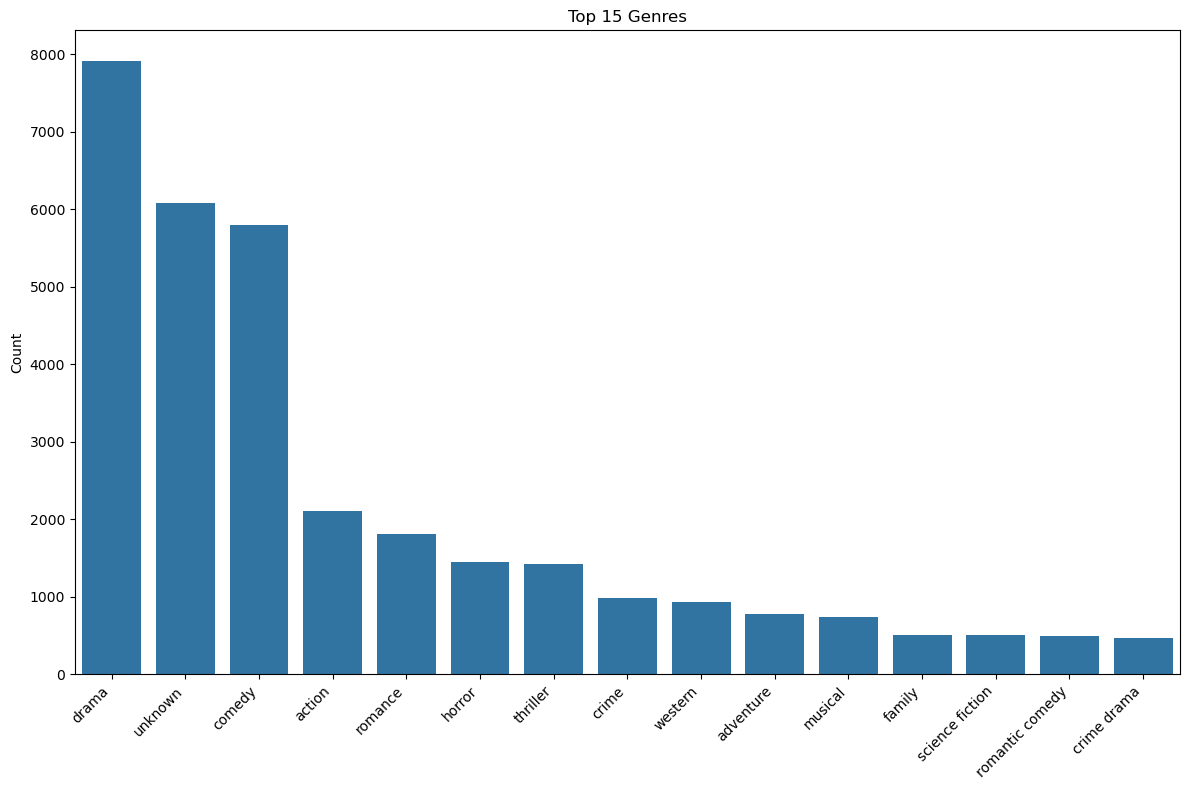

In [9]:
# Display genre counts sorted by frequency
print("Genre counts:")
for genre, count in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre}: {count}")

# Visualize genre distribution
plt.figure(figsize=(12, 8))
top_genres = {k: v for k, v in sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:15]}
sns.barplot(x=list(top_genres.keys()), y=list(top_genres.values()))
plt.title('Top 15 Genres')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [11]:
# 2.4 Text Preprocessing Functions

# Get WordNet POS tag
def get_wordnet_pos(tag):
    """Map POS tag to first character used by WordNetLemmatizer"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # Default to noun
        return wordnet.NOUN

def preprocess_text(text):
    """Comprehensive text preprocessing with POS tagging and lemmatization"""
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # POS tagging
    tagged_tokens = pos_tag(tokens)
    
    # Lemmatization with POS tags
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
        for word, tag in tagged_tokens
    ]
    
    # Remove short words (length < 3)
    filtered_tokens = [word for word in lemmatized_tokens if len(word) > 2]
    
    return filtered_tokens


In [13]:
def get_pos_distribution(tokens_list):
    """Calculate the distribution of POS tags in a list of tokens"""
    if not tokens_list:
        return {'noun_pct': 0, 'verb_pct': 0, 'adj_pct': 0, 'adv_pct': 0}
    
    tagged = pos_tag(tokens_list)
    total = len(tagged)
    
    pos_counts = {
        'noun_pct': sum(1 for _, tag in tagged if tag.startswith('N')) / total,
        'verb_pct': sum(1 for _, tag in tagged if tag.startswith('V')) / total,
        'adj_pct': sum(1 for _, tag in tagged if tag.startswith('J')) / total,
        'adv_pct': sum(1 for _, tag in tagged if tag.startswith('R')) / total
    }
    
    return pos_counts


In [15]:
# 2.5 Apply preprocessing to a sample plot to test
sample_plot = df_main['Plot'].iloc[0]
print(f"Original plot: {sample_plot[:100]}...")

sample_tokens = preprocess_text(sample_plot)
print(f"Processed tokens (first 20): {sample_tokens[:20]}")

sample_pos = get_pos_distribution(sample_tokens)
print(f"POS distribution: {sample_pos}")

Original plot: A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Ir...
Processed tokens (first 20): ['bartender', 'work', 'saloon', 'serve', 'drink', 'customer', 'fill', 'stereotypically', 'irish', 'man', 'bucket', 'beer', 'carrie', 'nation', 'follower', 'burst', 'inside', 'assault', 'irish', 'man']
POS distribution: {'noun_pct': 0.6458333333333334, 'verb_pct': 0.16666666666666666, 'adj_pct': 0.10416666666666667, 'adv_pct': 0.020833333333333332}


In [16]:
# 3. Genre Analysis and Standardization
# ----------------------------------

# 3.1 Filter rare genres
min_genre_count = 100
popular_genres = {genre for genre, count in genre_counts.items() if count >= min_genre_count}
print(f"\nKeeping {len(popular_genres)} genres that appear at least {min_genre_count} times:")
print(popular_genres)

# Function to filter rare genres from each movie
def filter_rare_genres(genre_text, popular_genres):
    if not isinstance(genre_text, str):
        return genre_text
    
    # Split and clean genres
    genres = re.split(r'[,|;/]', genre_text)
    genres = [g.strip() for g in genres if g.strip()]
    
    # Keep only popular genres
    filtered_genres = [g for g in genres if g in popular_genres]
    
    # Return comma-separated string of filtered genres
    if filtered_genres:
        return ', '.join(filtered_genres)
    else:
        return None  # Will be handled as NaN and can be dropped



Keeping 31 genres that appear at least 100 times:
{'film noir', 'musical comedy', 'anime', 'horror', 'musical', 'biography', 'social', 'mystery', 'fantasy', 'family', 'action', 'crime', 'crime drama', 'comedy', 'drama', 'comedy-drama', 'romantic comedy', 'unknown', 'comedy drama', 'historical', 'war', 'animation', 'sci-fi', 'adventure', 'science fiction', 'thriller', 'suspense', 'romance', 'animated', 'western', 'romantic drama'}


In [19]:
# Apply filtering
df_main['Genre'] = df_main['Genre'].apply(lambda x: filter_rare_genres(x, popular_genres))

# Remove rows where all genres were filtered out
df_filtered = df_main.dropna(subset=['Genre'])

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"Removed {len(df_main) - len(df_filtered)} rows where all genres were rare")

# Display first few rows
df_filtered.head()



Filtered dataset shape: (31577, 2)
Removed 3309 rows where all genres were rare


,Plot,Genre
0,"A bartender is working at a saloon, serving dr...",unknown
1,"The moon, painted with a smiling face hangs ov...",unknown
2,"The film, just over a minute long, is composed...",unknown
3,Lasting just 61 seconds and consisting of two ...,unknown
4,The earliest known adaptation of the classic f...,unknown


In [21]:
# Define major genres to keep
major_genres = [
    'drama', 'comedy', 'romance', 'action', 'crime', 'horror', 'thriller',
    'science fiction', 'musical', 'mystery', 'western', 'adventure', 
    'historical', 'war', 'animation', 'suspense', 'biography', 
    'social', 'family', 'fantasy'
]

# Define genre mapping
genre_mapping = {
    'sci-fi': 'science fiction',
    'film noir': 'thriller',
    'animated': 'animation',
    'documentary': 'drama',
    'noir film': 'thriller'
}

# Some genres map to multiple main genres
multiple_mappings = {
    'romantic comedy': ['comedy', 'romance'],
    'comedy-drama': ['comedy', 'drama'],
    'comedy drama': ['comedy', 'drama'],
    'crime drama': ['crime', 'drama'],
    'romantic drama': ['romance', 'drama'],
    'musical comedy': ['musical', 'comedy']
}

# List of genres to remove completely
genres_to_remove = ['unknown']

In [23]:
# Create a new dataframe to hold the standardized data
df_standardized = pd.DataFrame(columns=['Plot', 'Genre'])

In [25]:
# Process each row in the filtered dataframe
for index, row in df_filtered.iterrows():
    plot = row['Plot']
    genres_str = row['Genre']
    
    if not isinstance(genres_str, str):
        continue
        
    # Split genres
    genres = [g.strip() for g in re.split(r'[,|;/]', genres_str)]
    
    # Remove unwanted genres
    genres = [g for g in genres if g not in genres_to_remove]
    
    # If no genres left after removal, skip this row
    if not genres:
        continue
    
    # Map to standard genres
    standard_genres = set()
    
    for genre in genres:
        # Check if this genre maps to multiple main genres
        if genre in multiple_mappings:
            standard_genres.update(multiple_mappings[genre])
        # Check if this genre maps to a single main genre
        elif genre in genre_mapping:
            standard_genres.add(genre_mapping[genre])
        # Otherwise, keep the original genre if it's in our major genres list
        elif genre in major_genres:
            standard_genres.add(genre)
    
    # If we have standard genres, add this to our standardized dataframe
    if standard_genres:
        standard_genres_str = ', '.join(sorted(standard_genres))
        df_standardized = df_standardized._append({'Plot': plot, 'Genre': standard_genres_str}, ignore_index=True)

# Check the final shape
print(f"Original filtered dataset shape: {df_filtered.shape}")
print(f"Standardized dataset shape: {df_standardized.shape}")


Original filtered dataset shape: (31577, 2)
Standardized dataset shape: (25381, 2)


In [26]:
# 3.3 Second-level genre mapping for final set of genres

# Define more concise genre mappings for less frequent genres
final_genre_mapping = {
    # Map to drama
    'biography': 'drama',
    'historical': 'drama',
    'social': 'drama',
    'war': 'drama',
    
    # Map to action
    'adventure': 'action',
    'western': 'action',
    
    # Map to thriller
    'mystery': 'thriller',
    'suspense': 'thriller',
    
    # Map to comedy
    'musical': 'comedy',
    
    # Map to other categories
    'science fiction': 'fantasy',  # Combine sci-fi and fantasy
    'animation': 'family'          # Animation is often family-friendly
}

# Apply mapping function
def apply_mapping(genre, mapping):
    if genre in mapping:
        return mapping[genre]
    return genre

# Apply to the dataset
df_standardized['MappedGenre'] = df_standardized['Genre'].apply(
    lambda x: ', '.join([apply_mapping(g.strip(), final_genre_mapping) for g in x.split(',')]) if isinstance(x, str) else x
)

In [27]:
# Count frequencies of mapped genres
mapped_genres = []
for genres_str in df_standardized['MappedGenre']:
    if isinstance(genres_str, str):
        genres = [g.strip() for g in genres_str.split(',')]
        mapped_genres.extend(genres)

mapped_genre_counts = Counter(mapped_genres)
print("\nFrequency of final mapped genres:")
for genre, count in sorted(mapped_genre_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre}: {count}")


Frequency of final mapped genres:
drama: 9716
comedy: 7612
action: 3821
romance: 2412
thriller: 2374
crime: 1464
horror: 1450
fantasy: 1328
family: 1089


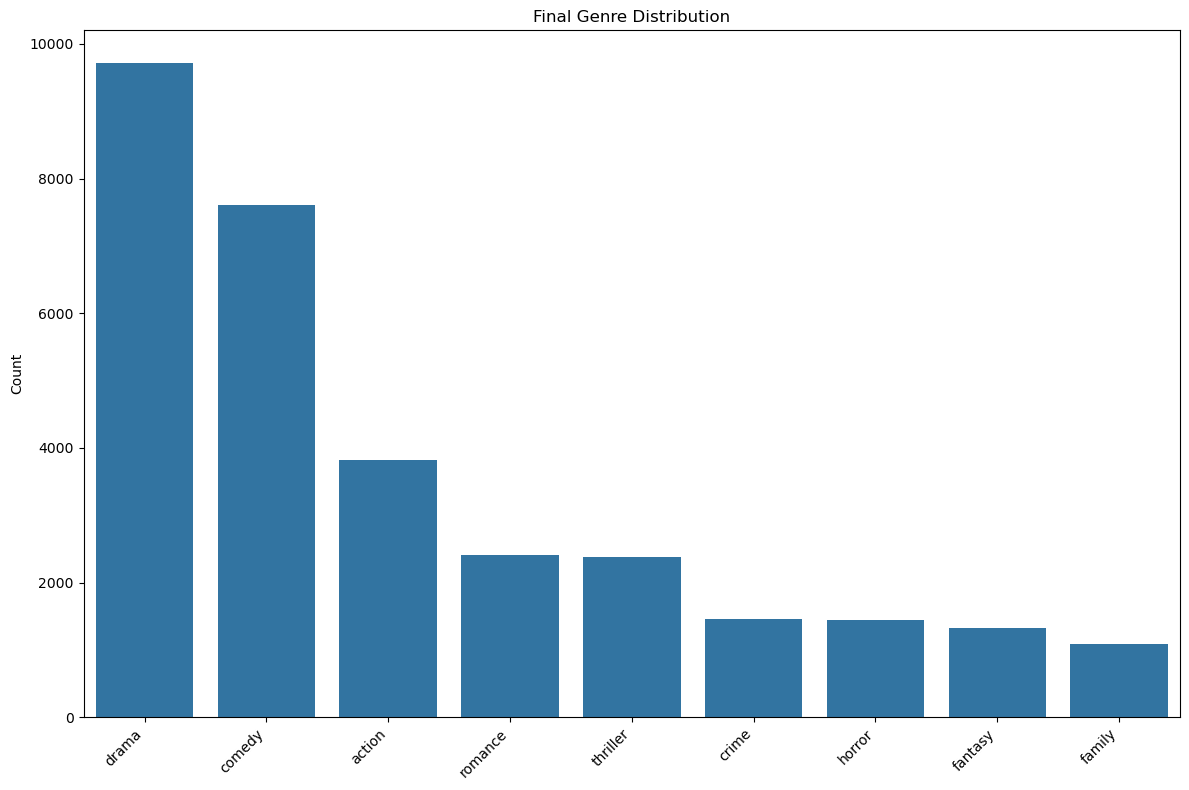

In [28]:
# Visualize final genre distribution
plt.figure(figsize=(12, 8))
genres = [k for k, v in sorted(mapped_genre_counts.items(), key=lambda x: x[1], reverse=True)]
counts = [v for k, v in sorted(mapped_genre_counts.items(), key=lambda x: x[1], reverse=True)]
sns.barplot(x=genres, y=counts)
plt.title('Final Genre Distribution')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [29]:
# 4. Feature Engineering
# ------------------

# Apply text preprocessing to all plots
df_standardized['processed_plots'] = df_standardized['Plot'].apply(preprocess_text)

# Display sample of processed text
df_standardized[['Plot', 'processed_plots']].head(2)

# Count unique words
all_tokens = [token for tokens in df_standardized['processed_plots'] for token in tokens]
word_counts = Counter(all_tokens)
unique_words = len(word_counts)
print(f"Number of unique words: {unique_words}")

# Display most common words
print("\nMost common words:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

Number of unique words: 132602

Most common words:
find: 28223
take: 27418
get: 25576
kill: 24193
tell: 22722
one: 21697
leave: 21400
make: 17920
back: 17203
love: 16594
father: 16503
see: 16224
try: 16085
return: 15845
two: 14947
come: 14563
friend: 14180
give: 14089
meet: 13788
home: 13509


In [39]:
# Create text column for machine learning models (join tokens back into strings)
df_standardized['processed_text'] = df_standardized['processed_plots'].apply(lambda tokens: ' '.join(tokens))

# Add POS distribution features
pos_features = df_standardized['processed_plots'].apply(get_pos_distribution)
pos_df = pd.DataFrame(pos_features.tolist())
df_standardized = pd.concat([df_standardized, pos_df], axis=1)


Distribution of genres per movie:
MappedGenre
1    20393
2     4306
3      506
4      144
5       26
6        5
7        1
Name: count, dtype: int64


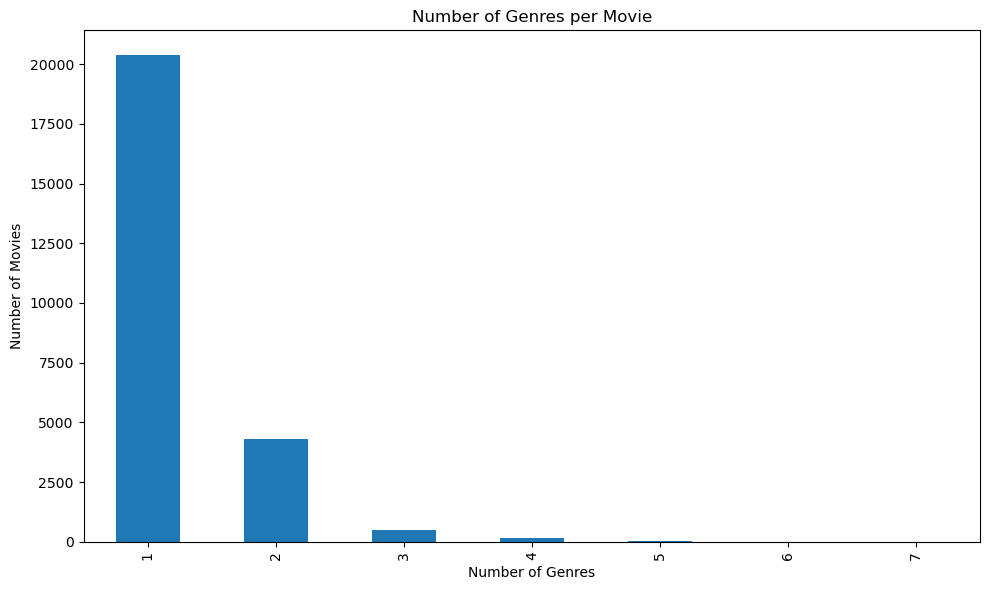

In [41]:
# Check the distribution of genres per movie
genre_counts = df_standardized['MappedGenre'].str.count(',') + 1
print("\nDistribution of genres per movie:")
print(genre_counts.value_counts().sort_index())

# Visualize the distribution
plt.figure(figsize=(10, 6))
genre_counts.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Genres per Movie')
plt.xlabel('Number of Genres')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

In [43]:
# 5. Dataset Preparation for Multi-label Classification
# -------------------------------------------------

# Convert comma-separated genres to lists
def get_genre_list(genre_string):
    if isinstance(genre_string, str):
        return [genre.strip() for genre in genre_string.split(',')]
    return []

# Convert genres to lists
genre_lists = df_standardized['MappedGenre'].apply(get_genre_list)

# Use Multi-label binarizer to transform genres into binary matrix
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(genre_lists)

# Get all possible genre labels
genre_classes = mlb.classes_
print(f"Number of unique genres: {len(genre_classes)}")
print(f"Genre classes: {genre_classes}")

# Split the data
X = df_standardized['processed_text']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Target shape: {y_train.shape}")

Number of unique genres: 9
Genre classes: ['action' 'comedy' 'crime' 'drama' 'family' 'fantasy' 'horror' 'romance'
 'thriller']
Training set size: 20304
Test set size: 5077
Target shape: (20304, 9)


In [45]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2),
    sublinear_tf=True
)


# Transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

TF-IDF features shape: (20304, 10000)


In [47]:
# 6. Multi-label Classification Models
# ---------------------------------

# Evaluation function to be used for all models
def evaluate_model(y_true, y_pred, genre_classes, model_name):
    """Evaluate model performance with appropriate metrics"""
    # Calculate performance metrics
    hamming = hamming_loss(y_true, y_pred)
    print(f"{model_name} - Hamming Loss: {hamming:.4f}")
    
    # Calculate subset accuracy (exact match)
    subset_accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} - Subset Accuracy (Exact Match): {subset_accuracy:.4f}")
    
    # Calculate Jaccard score (similarity coefficient)
    jaccard = jaccard_score(y_true, y_pred, average='samples')
    print(f"{model_name} - Jaccard Score: {jaccard:.4f}")
    
    # Calculate per-class metrics
    print(f"\n{model_name} - Classification Report:")
    report = classification_report(y_true, y_pred, target_names=genre_classes, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=genre_classes))
    
    # Calculate the average number of labels per sample
    avg_labels_pred = np.sum(y_pred, axis=1).mean()
    avg_labels_true = np.sum(y_true, axis=1).mean()
    print(f"{model_name} - Average number of genres per movie (true): {avg_labels_true:.2f}")
    print(f"{model_name} - Average number of genres per movie (predicted): {avg_labels_pred:.2f}")
    
    return {
        'hamming_loss': hamming,
        'exact_match': subset_accuracy,
        'jaccard_score': jaccard,
        'avg_labels_pred': avg_labels_pred,
        'avg_labels_true': avg_labels_true,
        'report': report
    }

In [49]:
# 6.1 Basic Logistic Regression (One-vs-Rest)
print("\nTraining One-vs-Rest Classifier...")

# Create base classifier
base_clf_ovr = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)

# Create and train One-vs-Rest classifier
ovr_clf = OneVsRestClassifier(base_clf_ovr, n_jobs=-1)
ovr_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_ovr = ovr_clf.predict(X_test_tfidf)

# Evaluate
ovr_results = evaluate_model(y_test, y_pred_ovr, genre_classes, "One-vs-Rest")


Training One-vs-Rest Classifier...
One-vs-Rest - Hamming Loss: 0.1004
One-vs-Rest - Subset Accuracy (Exact Match): 0.3514
One-vs-Rest - Jaccard Score: 0.4041

One-vs-Rest - Classification Report:
              precision    recall  f1-score   support

      action       0.83      0.37      0.51       786
      comedy       0.75      0.50      0.60      1424
       crime       0.47      0.05      0.10       294
       drama       0.70      0.54      0.61      1872
      family       0.97      0.15      0.26       209
     fantasy       0.79      0.28      0.42       275
      horror       0.85      0.34      0.49       282
     romance       0.73      0.22      0.34       476
    thriller       0.51      0.09      0.15       475

   micro avg       0.73      0.39      0.51      6093
   macro avg       0.73      0.28      0.39      6093
weighted avg       0.72      0.39      0.49      6093
 samples avg       0.45      0.42      0.42      6093

One-vs-Rest - Average number of genres per m

C:\Users\Yash_26\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Yash_26\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
# 6.2 Multi-Output Classification
print("\nTraining Multi-Output Classifier...")

# Create base classifier
base_clf_multi = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)

# Create and train multi-label classifier
multi_label_clf = MultiOutputClassifier(base_clf_multi, n_jobs=-1)
multi_label_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_multi = multi_label_clf.predict(X_test_tfidf)

# Evaluate
multi_results = evaluate_model(y_test, y_pred_multi, genre_classes, "Multi-Output")


Training Multi-Output Classifier...
Multi-Output - Hamming Loss: 0.1004
Multi-Output - Subset Accuracy (Exact Match): 0.3514
Multi-Output - Jaccard Score: 0.4041

Multi-Output - Classification Report:
              precision    recall  f1-score   support

      action       0.83      0.37      0.51       786
      comedy       0.75      0.50      0.60      1424
       crime       0.47      0.05      0.10       294
       drama       0.70      0.54      0.61      1872
      family       0.97      0.15      0.26       209
     fantasy       0.79      0.28      0.42       275
      horror       0.85      0.34      0.49       282
     romance       0.73      0.22      0.34       476
    thriller       0.51      0.09      0.15       475

   micro avg       0.73      0.39      0.51      6093
   macro avg       0.73      0.28      0.39      6093
weighted avg       0.72      0.39      0.49      6093
 samples avg       0.45      0.42      0.42      6093

Multi-Output - Average number of genres

C:\Users\Yash_26\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Yash_26\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# 6.3 Classifier Chains
print("\nTraining Classifier Chain model...")

# Calculate genre frequencies in training data
genre_frequencies = y_train.sum(axis=0)

# Sort genres by frequency (most common first)
chain_order = np.argsort(-genre_frequencies)
print("Chain order based on genre frequency:")
for i, idx in enumerate(chain_order):
    print(f"{i+1}. {genre_classes[idx]} ({genre_frequencies[idx]} occurrences)")

# Create base classifier with balanced class weights
base_clf_chain = LogisticRegression(
    C=1.0, 
    solver='liblinear', 
    max_iter=1000, 
    class_weight='balanced'
)

# Create and train classifier chain
chain_clf = ClassifierChain(
    base_clf_chain, 
    order=chain_order,
    random_state=42
)
chain_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_chain = chain_clf.predict(X_test_tfidf)

# Evaluate
chain_results = evaluate_model(y_test, y_pred_chain, genre_classes, "Classifier Chain")


Training Classifier Chain model...
Chain order based on genre frequency:
1. drama (7591 occurrences)
2. comedy (5915 occurrences)
3. action (2955 occurrences)
4. romance (1936 occurrences)
5. thriller (1837 occurrences)
6. crime (1170 occurrences)
7. horror (1168 occurrences)
8. fantasy (1032 occurrences)
9. family (831 occurrences)
Classifier Chain - Hamming Loss: 0.1260
Classifier Chain - Subset Accuracy (Exact Match): 0.3567
Classifier Chain - Jaccard Score: 0.5236

Classifier Chain - Classification Report:
              precision    recall  f1-score   support

      action       0.54      0.69      0.60       786
      comedy       0.58      0.64      0.61      1424
       crime       0.30      0.56      0.40       294
       drama       0.61      0.71      0.66      1872
      family       0.57      0.39      0.47       209
     fantasy       0.51      0.64      0.57       275
      horror       0.61      0.70      0.65       282
     romance       0.37      0.59      0.46       

In [55]:
# 7. Model Evaluation and Comparison
# -------------------------------

# 7.1 Compare all models
print("\nModel Performance Comparison:")
print("=============================")

models_results = {
    'One-vs-Rest': ovr_results,
    'Multi-Output': multi_results,
    'Classifier Chain': chain_results
}

# Create comparison dataframe
comparison_metrics = ['hamming_loss', 'exact_match', 'jaccard_score', 'avg_labels_pred']
comparison_df = pd.DataFrame(
    {model: [results[metric] for metric in comparison_metrics] for model, results in models_results.items()},
    index=['Hamming Loss', 'Exact Match', 'Jaccard Score', 'Avg Labels Predicted']
)

print(comparison_df)

# Add true average labels as reference
true_avg_labels = models_results['One-vs-Rest']['avg_labels_true']
print(f"True average labels per movie: {true_avg_labels:.2f}")


Model Performance Comparison:
                      One-vs-Rest  Multi-Output  Classifier Chain
Hamming Loss             0.100409      0.100409          0.126015
Exact Match              0.351389      0.351389          0.356707
Jaccard Score            0.404090      0.404090          0.523567
Avg Labels Predicted     0.644278      0.644278          1.459720
True average labels per movie: 1.20


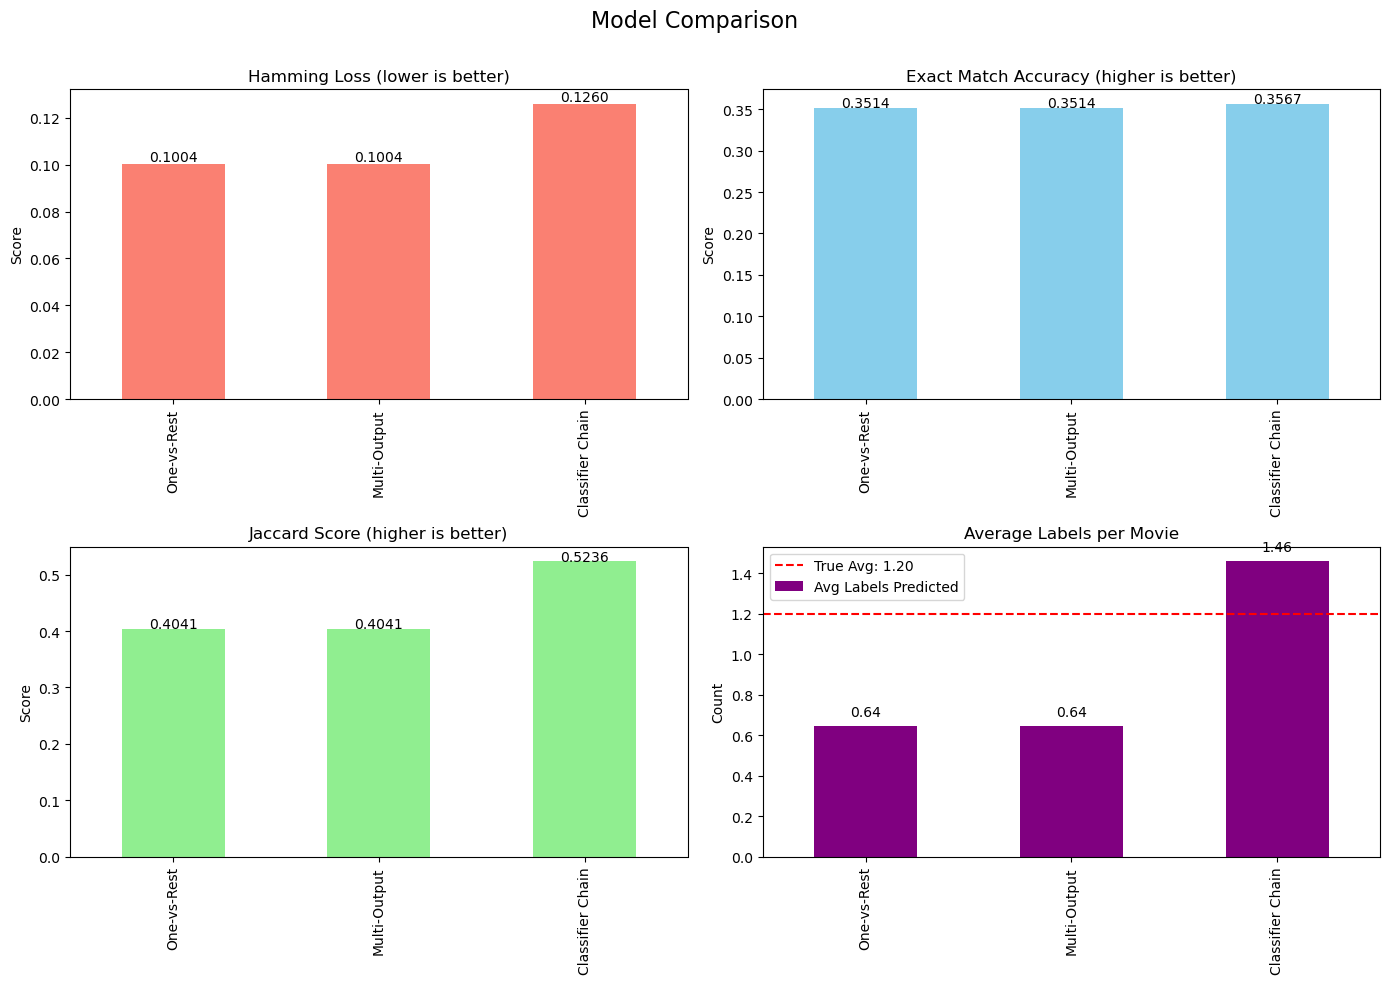

In [57]:
# 7.2 Visualize model comparison
# Create subplots for metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison', fontsize=16)

# Hamming Loss (lower is better)
ax1 = axes[0, 0]
comparison_df.loc['Hamming Loss'].plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title('Hamming Loss (lower is better)')
ax1.set_ylabel('Score')
for i, v in enumerate(comparison_df.loc['Hamming Loss']):
    ax1.text(i, v + 0.001, f"{v:.4f}", ha='center')

# Exact Match Accuracy (higher is better)
ax2 = axes[0, 1]
comparison_df.loc['Exact Match'].plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Exact Match Accuracy (higher is better)')
ax2.set_ylabel('Score')
for i, v in enumerate(comparison_df.loc['Exact Match']):
    ax2.text(i, v + 0.001, f"{v:.4f}", ha='center')

# Jaccard Score (higher is better)
ax3 = axes[1, 0]
comparison_df.loc['Jaccard Score'].plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Jaccard Score (higher is better)')
ax3.set_ylabel('Score')
for i, v in enumerate(comparison_df.loc['Jaccard Score']):
    ax3.text(i, v + 0.001, f"{v:.4f}", ha='center')

# Average Labels
ax4 = axes[1, 1]
comparison_df.loc['Avg Labels Predicted'].plot(kind='bar', ax=ax4, color='purple')
ax4.axhline(y=true_avg_labels, color='r', linestyle='--', label=f'True Avg: {true_avg_labels:.2f}')
ax4.set_title('Average Labels per Movie')
ax4.set_ylabel('Count')
ax4.legend()
for i, v in enumerate(comparison_df.loc['Avg Labels Predicted']):
    ax4.text(i, v + 0.05, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [59]:
# 7.3 Plot confusion matrices for the best model
# Find the best model based on Hamming Loss
best_model_name = comparison_df.loc['Hamming Loss'].idxmin()
print(f"\nPlotting confusion matrices for best model: {best_model_name}")

# Get predictions from the best model
if best_model_name == 'One-vs-Rest':
    y_pred_best = y_pred_ovr
elif best_model_name == 'Multi-Output':
    y_pred_best = y_pred_multi
else:
    y_pred_best = y_pred_chain



Plotting confusion matrices for best model: One-vs-Rest


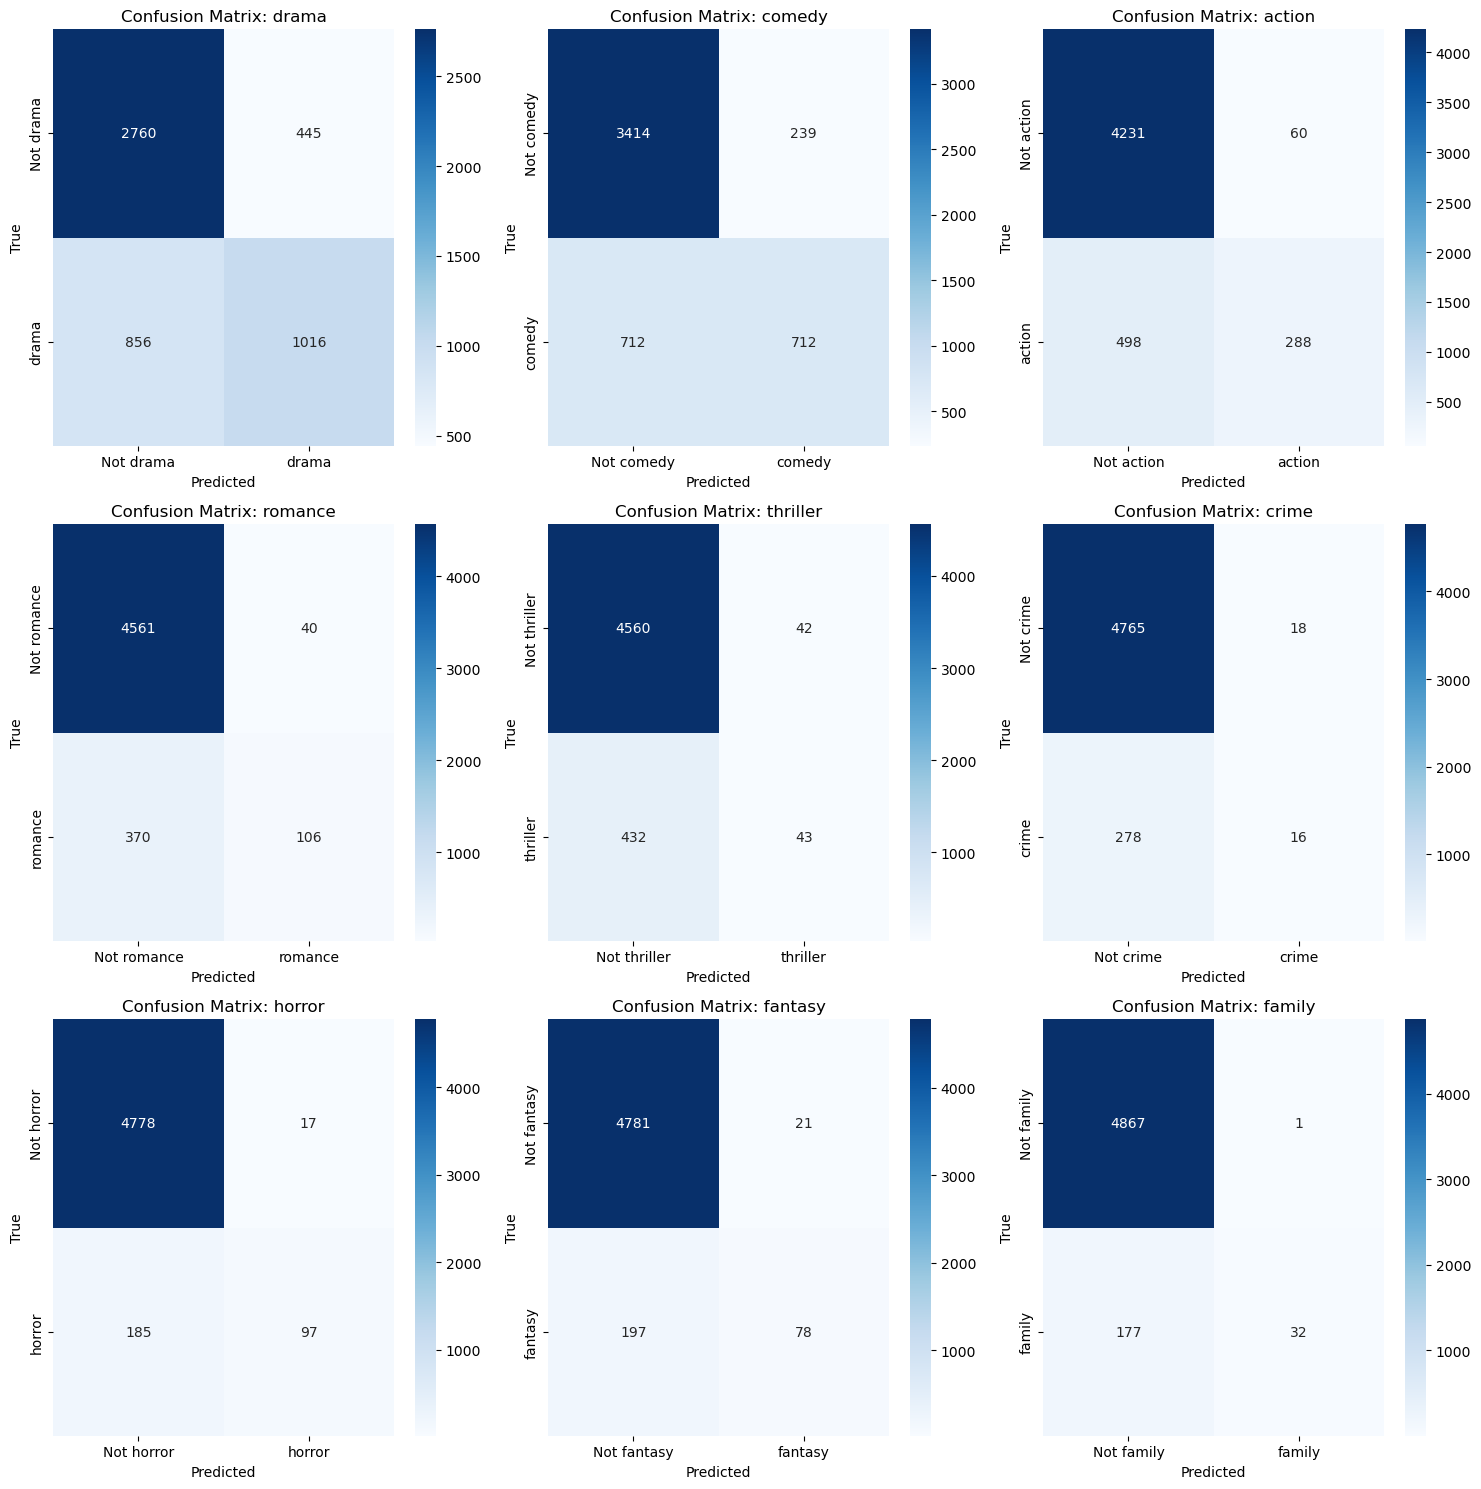

In [61]:
# Plot confusion matrices for top genres
plt.figure(figsize=(15, 15))
# Get top genres by frequency
top_genre_indices = np.argsort(-genre_frequencies)[:9]  # Top 9 genres

for i, idx in enumerate(top_genre_indices):
    genre = genre_classes[idx]
    plt.subplot(3, 3, i+1)
    cm = confusion_matrix(y_test[:, idx], y_pred_best[:, idx])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not '+genre, genre], 
                yticklabels=['Not '+genre, genre])
    plt.title(f'Confusion Matrix: {genre}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()


In [67]:
# 8. Predictions and Analysis
# -----------------------

# 8.1 Create a function to predict genres for new plot texts
def predict_genres(plot_text, vectorizer, model, mlb, threshold=0.3):
    """
    Predict genres for a new plot text
    Returns predicted genres with probabilities
    """
    # Preprocess the text
    tokens = preprocess_text(plot_text)
    processed_text = ' '.join(tokens)
    
    # Transform the text to TF-IDF features
    X = vectorizer.transform([processed_text])
    
    # For models without predict_proba, just use predict
    if not hasattr(model, 'predict_proba'):
        y_pred = model.predict(X)[0]
        predictions = [(genre, 1.0) for i, genre in enumerate(mlb.classes_) if y_pred[i] == 1]
        return predictions
    
    # Handling for different model types with predict_proba
    predictions = []
    genres = mlb.classes_
    
    # Special handling for OneVsRestClassifier
    if isinstance(model, OneVsRestClassifier):
        # OneVsRest returns decision function scores or single array of probabilities
        y_scores = model.predict_proba(X)[0]
        for i, score in enumerate(y_scores):
            if score >= threshold:
                predictions.append((genres[i], float(score)))
    
    # Special handling for MultiOutputClassifier
    elif isinstance(model, MultiOutputClassifier):
        # MultiOutputClassifier returns a list of probability arrays for each label
        for i, estimator in enumerate(model.estimators_):
            if i < len(genres):  # Safety check
                proba = estimator.predict_proba(X)[0]
                if len(proba) > 1:  # Binary classification
                    score = proba[1]  # Probability of positive class
                    if score >= threshold:
                        predictions.append((genres[i], float(score)))
    
    # Special handling for ClassifierChain
    elif isinstance(model, ClassifierChain):
        # First get the binary predictions
        y_pred = model.predict(X)[0]
        # For classifier chain, we don't have direct access to probabilities for each class
        # So we'll use the binary predictions with a default score
        predictions = [(genre, 0.8) for i, genre in enumerate(genres) if y_pred[i] == 1]
    
    # Generic fallback - just use predict
    else:
        y_pred = model.predict(X)[0]
        predictions = [(genre, 1.0) for i, genre in enumerate(mlb.classes_) if y_pred[i] == 1]
    
    # Sort by probability (descending)
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions

# Select the best model for predictions
if best_model_name == 'One-vs-Rest':
    best_model = ovr_clf
elif best_model_name == 'Multi-Output':
    best_model = multi_label_clf
else:
    best_model = chain_clf


In [69]:
# 8.2 Test with example plots
example_plots = [
    "A detective investigates a series of murders in a small town.",
    "Two people from different social backgrounds fall in love despite their families' objections.",
    "A spaceship crew discovers an alien life form that starts killing them one by one.",
    "A comedian struggles with addiction while trying to revive his failing career.",
    "A group of friends plan the perfect heist to rob a bank."
]

print("\nTesting the model with example plots:")
for i, plot in enumerate(example_plots):
    print(f"\nExample {i+1}: {plot}")
    predictions = predict_genres(plot, vectorizer, best_model, mlb)
    if predictions:
        print("Predicted genres:")
        for genre, prob in predictions:
            print(f"  {genre}: {prob:.4f}")
    else:
        print("No genres predicted above threshold.")


Testing the model with example plots:

Example 1: A detective investigates a series of murders in a small town.
Predicted genres:
  crime: 0.3747

Example 2: Two people from different social backgrounds fall in love despite their families' objections.
Predicted genres:
  drama: 0.7057
  romance: 0.4508

Example 3: A spaceship crew discovers an alien life form that starts killing them one by one.
Predicted genres:
  fantasy: 0.3823

Example 4: A comedian struggles with addiction while trying to revive his failing career.
Predicted genres:
  drama: 0.5063
  comedy: 0.3523

Example 5: A group of friends plan the perfect heist to rob a bank.
Predicted genres:
  comedy: 0.4443
  crime: 0.3455


In [71]:
# 8.3 Analyze genre co-occurrence
# Create co-occurrence matrix
co_occurrence = np.dot(y_train.T, y_train)
np.fill_diagonal(co_occurrence, 0)  # Remove self-co-occurrences

# Convert to DataFrame for better readability
co_df = pd.DataFrame(co_occurrence, index=genre_classes, columns=genre_classes)

In [73]:
# Display top co-occurrences
print("\nTop Genre Co-occurrences:")
co_pairs = []
for i in range(len(genre_classes)):
    for j in range(i+1, len(genre_classes)):
        co_pairs.append((genre_classes[i], genre_classes[j], co_occurrence[i, j]))

# Sort by co-occurrence count (descending)
co_pairs.sort(key=lambda x: x[2], reverse=True)

# Display top 10 co-occurring pairs
for genre1, genre2, count in co_pairs[:10]:
    print(f"{genre1} + {genre2}: {count} occurrences")



Top Genre Co-occurrences:
comedy + drama: 723 occurrences
comedy + romance: 668 occurrences
crime + drama: 561 occurrences
drama + romance: 455 occurrences
action + drama: 364 occurrences
action + comedy: 216 occurrences
action + fantasy: 157 occurrences
drama + thriller: 142 occurrences
action + romance: 133 occurrences
action + crime: 122 occurrences


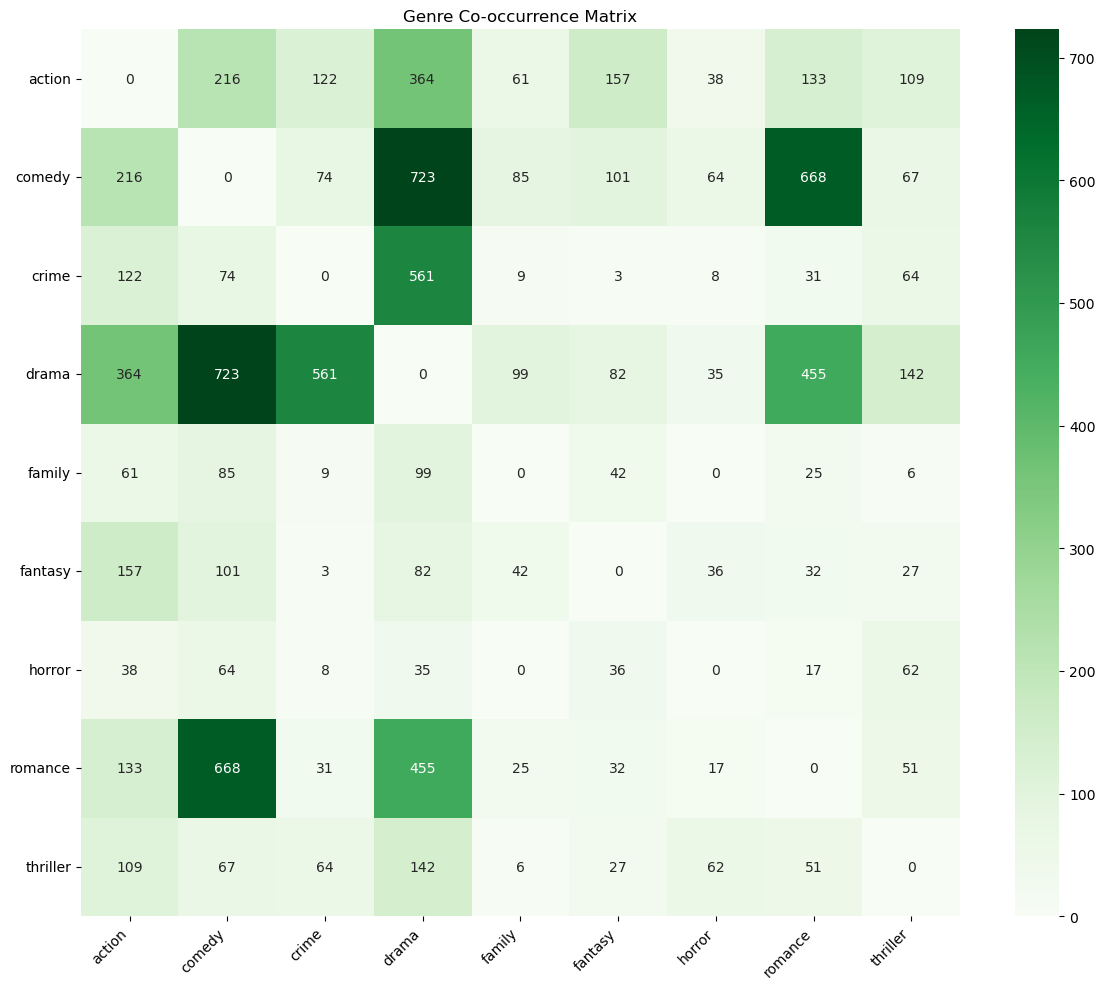

In [75]:
# Visualize co-occurrence for top genres
plt.figure(figsize=(12, 10))
top_genres_mask = np.sum(y_train, axis=0) > 100  # Genres with >100 movies
top_genres_idx = np.where(top_genres_mask)[0]
top_genres = [genre_classes[i] for i in top_genres_idx]

# Create a subset of the co-occurrence matrix
top_co_occurrence = co_occurrence[top_genres_mask][:, top_genres_mask]

# Plot heatmap
sns.heatmap(top_co_occurrence, annot=True, fmt='d', cmap='Greens',
           xticklabels=top_genres, yticklabels=top_genres)
plt.title('Genre Co-occurrence Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [77]:
# 9. Save Models and Components
# --------------------------
print("\nSaving models and components...")
joblib.dump(ovr_clf, 'onevsrest_genre_classifier.pkl')
joblib.dump(multi_label_clf, 'multioutput_genre_classifier.pkl')
joblib.dump(chain_clf, 'classifier_chain_genre_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(mlb, 'genre_binarizer.pkl')
print("Models and components saved successfully!")


Saving models and components...
Models and components saved successfully!


In [81]:
# 10. Summary and Conclusions
# -----------------------
print("\nSummary and Conclusions:")
print("=======================")
print(f"1. Dataset contained {len(df_standardized)} movies after preprocessing")
print(f"2. Final classification used {len(genre_classes)} unique genres")
print(f"3. Best performing model: {best_model_name}")

best_metrics = models_results[best_model_name]
print(f"   - Hamming Loss: {best_metrics['hamming_loss']:.4f}")
print(f"   - Exact Match Accuracy: {best_metrics['exact_match']:.4f}")
print(f"   - Jaccard Score: {best_metrics['jaccard_score']:.4f}")

print("4. Key insights:")
print("   - Movies have an average of {:.2f} genres".format(true_avg_labels))
print("   - Most frequent genre pairs:")
for genre1, genre2, count in co_pairs[:3]:
    print(f"     * {genre1} + {genre2}: {count} occurrences")

print("\nThe multi-label classification pipeline successfully predicts movie genres from plot descriptions.")


Summary and Conclusions:
1. Dataset contained 25381 movies after preprocessing
2. Final classification used 9 unique genres
3. Best performing model: One-vs-Rest
   - Hamming Loss: 0.1004
   - Exact Match Accuracy: 0.3514
   - Jaccard Score: 0.4041
4. Key insights:
   - Movies have an average of 1.20 genres
   - Most frequent genre pairs:
     * comedy + drama: 723 occurrences
     * comedy + romance: 668 occurrences
     * crime + drama: 561 occurrences

The multi-label classification pipeline successfully predicts movie genres from plot descriptions.
